# Fauna Classification Project

#### Imports

In [11]:
import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [12]:
# solutions I used for image processing used older versions of keras, so I downgraded

#pip install keras==2.6

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
path = "data/animals_data/raw-img"

image_data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        image_data["imgpath"].append(fpath)
        image_data["labels"].append(folder)
      

df = pd.DataFrame(image_data) 

#Convert labels to numbers -- many species will have similar names, thus numbers will make for clearer distinctions
label_enc = LabelEncoder()
df['encoded_labels'] = label_enc.fit_transform(df['labels'])

In [15]:
df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
21590,data/animals_data/raw-img\spider\OIP-gXkw8eyrn...,spider,8
6337,data/animals_data/raw-img\chicken\OIP-tGIy1WSi...,chicken,2
6032,data/animals_data/raw-img\chicken\OIP-phOHq4mO...,chicken,2
22295,data/animals_data/raw-img\spider\OIP-llpwljKwZ...,spider,8
20032,data/animals_data/raw-img\spider\OIP-1whi6SMIA...,spider,8
12065,data/animals_data/raw-img\dog\OIP-QlsWPQiVBeYt...,dog,4
24262,data/animals_data/raw-img\spider\OIP-_CCJ0SNnD...,spider,8
7979,data/animals_data/raw-img\cow\OIP-mn_3StuL7GcY...,cow,3
11235,data/animals_data/raw-img\dog\OIP-LDpU3ML5tsQp...,dog,4
3811,data/animals_data/raw-img\chicken\105.jpeg,chicken,2


In [16]:
print("Shape: \n", df.shape)

print("\nNulls Sum: \n")
print(df.isnull().sum())

print("\nNumber of unique values: \n")
print(df.nunique())

print("\nNumber of images per category : \n" )
print(df.labels.value_counts())  

Shape: 
 (26179, 3)

Nulls Sum: 

imgpath           0
labels            0
encoded_labels    0
dtype: int64

Number of unique values: 

imgpath           26179
labels               10
encoded_labels       10
dtype: int64

Number of images per category : 

labels
dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: count, dtype: int64


In [17]:
#Splitting images into Training set and Testing set

train_df, process_df = train_test_split(df,  train_size= 0.7 , shuffle=True, random_state=42)
cv_df , test_df = train_test_split(process_df ,  train_size= 0.5 , shuffle=True, random_state=42)
train_df = train_df.reset_index(drop=True)
cv_df = cv_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

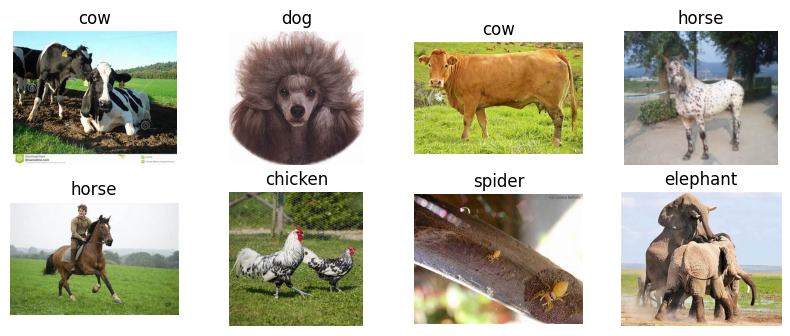

In [18]:
plt.figure(figsize=(10,8))
for x, row in test_df.sample(n=8).reset_index().iterrows():
    plt.subplot(4,4,x+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#### Data-loaders

In [19]:
#Loads data into the model for training

batch_size = 24
img_size = (200, 200)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # future augmentation?
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=cv_df,
    x_col='imgpath',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 18325 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.


#### Modeling

In [20]:
# base model
base_model = tf.keras.applications.EfficientNetB2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze layers of a base neural network
for i, layer in enumerate(base_model.layers):
    base_model.layers[i].trainable = False

In [21]:
#Testing Modeling -- used a few examples from kaggle for reference

total_classes = len(set(train_images.classes))


# Augementation
aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.4),
  layers.experimental.preprocessing.RandomContrast(0.4),
], name='Aug_Layer')


#input / output layering
inputs = layers.Input(shape = (200,200,3), name='in_layer')
t = aug(inputs)
pretrain_out = base_model(t, training = False)
t = layers.Dense(256)(pretrain_out)
t = layers.Activation(activation="relu")(t) 
t = BatchNormalization()(t)
t = layers.Dropout(0.4)(t)
t = layers.Dense(total_classes)(t)
out_lay = layers.Activation(activation="softmax", dtype=tf.float32, name='activ_layer')(t)
model = Model(inputs=inputs, outputs=out_lay)



model.compile(
    optimizer=Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
Aug_Layer (Sequential)       (None, 200, 200, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense (Dense)                (None, 256)               360704    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [23]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=75,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/75
764/764 [==============================] - 43s 47ms/step - loss: 0.5675 - accuracy: 0.8168 - val_loss: 0.1741 - val_accuracy: 0.9524
Epoch 2/75
764/764 [==============================] - 30s 39ms/step - loss: 0.4554 - accuracy: 0.8535 - val_loss: 0.1822 - val_accuracy: 0.9503
Epoch 3/75
764/764 [==============================] - 32s 42ms/step - loss: 0.4310 - accuracy: 0.8595 - val_loss: 0.1630 - val_accuracy: 0.9539
Epoch 4/75
764/764 [==============================] - 33s 40ms/step - loss: 0.4216 - accuracy: 0.8627 - val_loss: 0.1670 - val_accuracy: 0.9587
Epoch 5/75
764/764 [==============================] - 31s 40ms/step - loss: 0.4014 - accuracy: 0.8720 - val_loss: 0.1542 - val_accuracy: 0.9565
Epoch 6/75
764/764 [==============================] - 33s 43ms/step - loss: 0.4050 - accuracy: 0.8705 - val_loss: 0.1790 - val_accuracy: 0.9552
Epoch 7/75
764/764 [==============================] - 31s 41ms/step - loss: 0.3901 - accuracy: 0.8757 - val_loss: 0.1886 - val_accuracy:

In [24]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

F1 Score: 0.9603040900205894
              precision    recall  f1-score   support

   butterfly       0.98      0.98      0.98       291
         cat       0.97      0.94      0.96       270
     chicken       0.98      0.98      0.98       457
         cow       0.90      0.91      0.90       303
         dog       0.95      0.96      0.96       729
    elephant       0.98      0.99      0.98       211
       horse       0.95      0.95      0.95       383
       sheep       0.93      0.93      0.93       256
      spider       0.99      0.99      0.99       719
    squirrel       0.97      0.98      0.97       308

    accuracy                           0.96      3927
   macro avg       0.96      0.96      0.96      3927
weighted avg       0.96      0.96      0.96      3927

